## Brain Tumor Classification with CNNs

### Imports

In [1]:
# Common Python imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import matplotlib.image as mpimg
from IPython.display import Image
import random
from tqdm import trange
# import tqdm.notebook as tqdm

# Torch imports
import torch as th
from torch import Tensor
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Typining hints
from typing import List, Union, Callable

# Change cwd to the parent directory and add it to the Python path
os.chdir("/Users/stefanolusardi/Desktop/deep-learning-project")
sys.path.append(os.getcwd())
print(f"Current working directory: 📂 {os.getcwd()}")

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
	},
)

# Model import
from models.alexnet import AlexNet_128
from models.custom_cnn import CustomCNN
from models.vgg16 import VGG16_128
from models.vit import VisionTransformer

# Dataset loader
from utils.datasets import load_segmentation, load_single

# Utils imports
from utils.analysis import *
from utils.metrics import *
from utils.train import *

Current working directory: 📂 /Users/stefanolusardi/Desktop/deep-learning-project


### Hyperparameters

In [2]:
# Training hyperparameters
PERCENTAGE: float   = 0.5
SPLIT: float        = 0.9
N_FILTERS: int      = 32
IMG_SIZE: int       = 128
EPOCHS: int         = 50
BATCH_TRAIN: int    = 64
BATCH_VALID: int    = 64
LR: float           = 1e-4
DEVICE_AUTODETECT: bool = True


# Loss function
CRITERION: Union[th.nn.Module, Callable[[th.Tensor, th.Tensor], th.Tensor]] = (
	th.nn.CrossEntropyLoss(reduction="mean")
)

EVAL_CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="sum")
)

# Dataset, Models and Metrics folders
DATASETS: str = "datasets"
CLASSIFICATION: str = os.path.join(DATASETS, "classification")
TRAINING: str = os.path.join(CLASSIFICATION, "Training")
TESTING: str = os.path.join(CLASSIFICATION, "Testing")
SAVE_MODELS_PATH: str = f"models/saved_models"
SAVE_METRICS_PATH: str = f"models/saved_metrics"


# Device setup
device: th.device = th.device(
    "mps" if th.backends.mps.is_available() and DEVICE_AUTODETECT else "cpu"
)
print(f"Using device: 💻 {device}")

Using device: 💻 mps


### Dataset

We start off with a small exploratory analysis of the dataset. We will load the dataset and check the distribution of the classes.

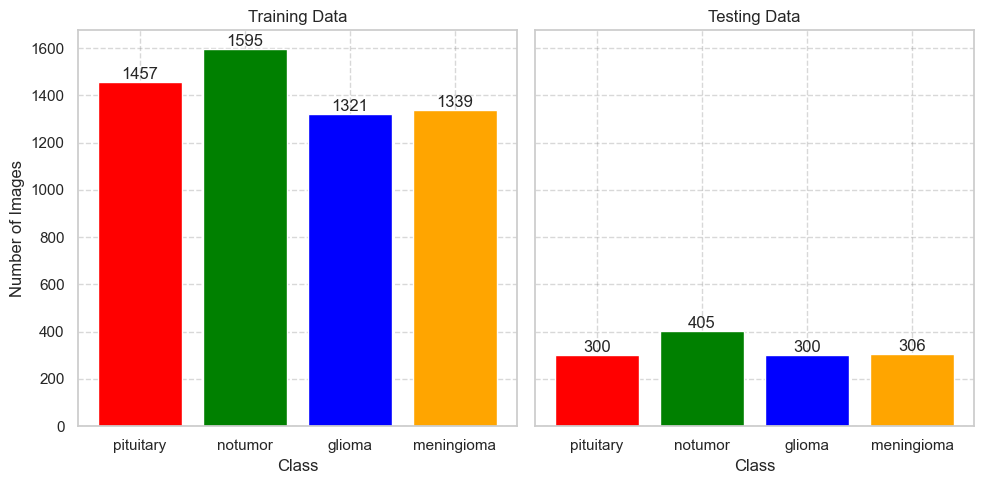

In [3]:
def count_images_in_classes(base_dir):
    counts = {}
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

# Count the images in each class for training and testing
train_counts = count_images_in_classes(TRAINING)
test_counts = count_images_in_classes(TESTING)

# Create DataFrames for plotting
train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
test_df = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])

# Define a color palette for the classes
color_palette = {
    'glioma': 'blue',
    'meningioma': 'orange',
    'notumor': 'green',
    'pituitary': 'red'
}

# Plot the counts
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Training data plot
bars = axes[0].bar(train_df['Class'], train_df['Count'], color=[color_palette[class_name] for class_name in train_df['Class']])
axes[0].set_title('Training Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')

# Add annotations on top of the bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

# Testing data plot
bars = axes[1].bar(test_df['Class'], test_df['Count'], color=[color_palette[class_name] for class_name in test_df['Class']])
axes[1].set_title('Testing Data')
axes[1].set_xlabel('Class')

# Add annotations on top of the bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

We can also attempt to see how the images look like.

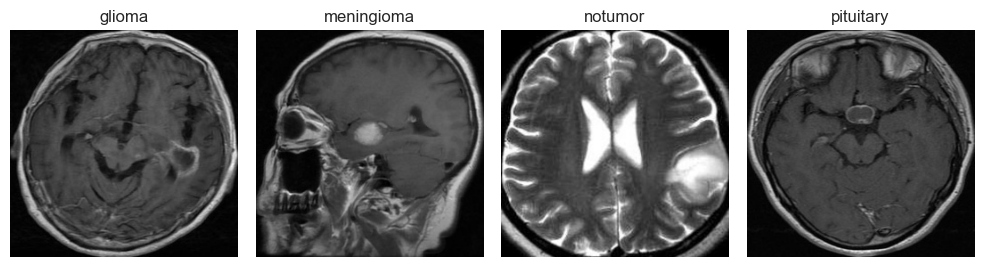

In [4]:
def get_random_image_from_class(base_dir, class_name):
    class_dir = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_dir)
    random_image = random.choice(image_files)
    return os.path.join(class_dir, random_image)

# Define the path to the training directory
train_dir = TRAINING

# Define the class names
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Get a random image from each class
random_images = [get_random_image_from_class(train_dir, class_name) for class_name in classes]

# Plot the images in a 1x4 grid
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for ax, img_path, class_name in zip(axes, random_images, classes):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Models

Let's start working on the first model (custom CNN). Define the dataset and the transformations first.

In [5]:
# Define the transformations for the training datasets (data augmentation)
transform_train_CNN = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation and hue
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the transformations for the testing datasets
transform_test_CNN = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/classification/Training'
test_dir = 'datasets/classification/Testing'

# Create the datasets
train_dataset_CNN = datasets.ImageFolder(root=train_dir, transform=transform_train_CNN)
test_dataset_CNN = datasets.ImageFolder(root=test_dir, transform=transform_test_CNN)

# Create the DataLoaders
train_loader_CNN: DataLoader = DataLoader(train_dataset_CNN, batch_size=BATCH_TRAIN, shuffle=True)
test_loader_CNN = DataLoader(test_dataset_CNN, batch_size=BATCH_VALID, shuffle=False)

# Example of iterating through the DataLoader
for images, labels in train_loader_CNN:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


Let's visualize some images from the dataset.

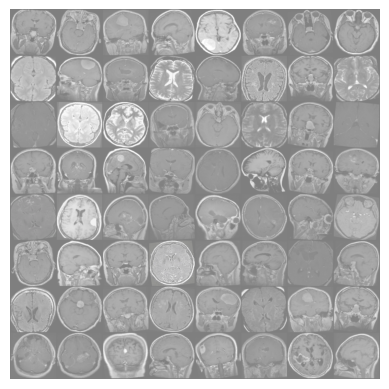

3 3 1 3 1 0 3 3 2 1 0 2 0 2 3 2 0 2 2 0 3 2 3 0 3 0 1 3 0 2 3 0 2 1 0 3 0 0 0 2 3 3 3 2 3 0 0 3 2 3 3 2 1 2 1 3 0 0 1 3 1 0 0 3


In [6]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get some random training images
dataiter = iter(train_loader_CNN)
images, labels = next(dataiter)

# Show images
imshow(tv.utils.make_grid(images))

# Print labels
print(' '.join(f'{labels[j]}' for j in range(len(labels))))

Let's define the custom CNN model.

In [7]:
model: CustomCNN = CustomCNN().to(device)
model.train()

CustomCNN(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(9, 9), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Mish()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Mish()
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Mish()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatt

See the number of parameters in the model.

In [8]:
# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 3001156


Define optimizer and scheduler.

In [9]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=LR, weight_decay=1e-5 # L2 regularization
)

# Let's define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

Train the model.

In [10]:
eval_losses_CNN: List[float] = []
eval_acc_CNN: List[float] = []
test_acc_CNN: List[float] = []
confidence_scores_CNN: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader_CNN):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()
        
    # Step the scheduler
    scheduler.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader_CNN):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses_CNN.append(trackingmetric / num_elem)
        eval_acc_CNN.append(trackingcorrect / num_elem)
        confidence_scores_CNN.append(softmax_probs.max(dim=1).values.mean())

Training epoch: 100%|██████████| 50/50 [34:00<00:00, 40.82s/it]


Plot the training loss and the accuracy of the model over the epochs.

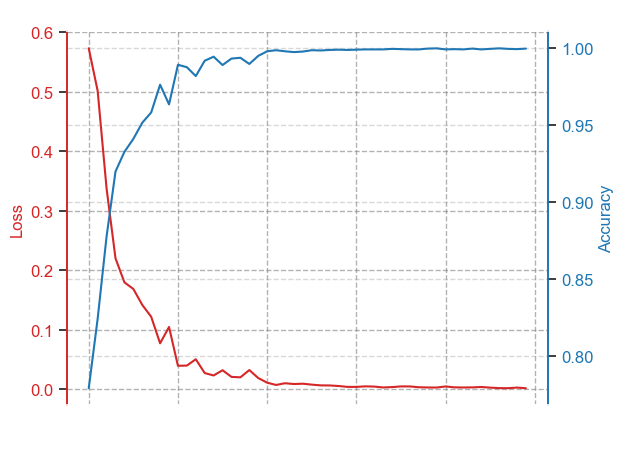

In [11]:
loss_color = "tab:red"
acc_color = "tab:blue"

# Create figure with transparent background
fig, ax1 = plt.subplots()

# Set background color to transparent
fig.patch.set_alpha(0)  # Set the figure background to transparent
ax1.set_facecolor((1, 1, 1, 0))  # Set axes background to transparent

# Set labels with white color
ax1.set_xlabel("Epoch", color="white", fontsize=12)
ax1.set_ylabel("Loss", color=loss_color, fontsize=12)
ax1.plot(eval_losses_CNN, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color, labelsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color, fontsize=12)
ax2.plot(eval_acc_CNN, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color, labelsize=12)

# Change ticks and spine colors to white
ax1.tick_params(axis='x', colors='white')
ax2.tick_params(axis='x', colors='white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color(loss_color)
ax1.spines['right'].set_color(acc_color)

ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
ax2.spines['left'].set_color(loss_color)
ax2.spines['right'].set_color(acc_color)

# Set title color to white
plt.title("Training loss and accuracy", fontsize=14, color='white')

# Adjust layout
fig.tight_layout()

plt.show()

See the final accuracy of the model.

In [12]:
print(f"Final training loss: {eval_losses_CNN[-1]}")
print(f"Final training accuracy: {eval_acc_CNN[-1]}")

Final training loss: 0.0013610745095537
Final training accuracy: 0.9996498599439776


Let's analyze the confidences of the model.

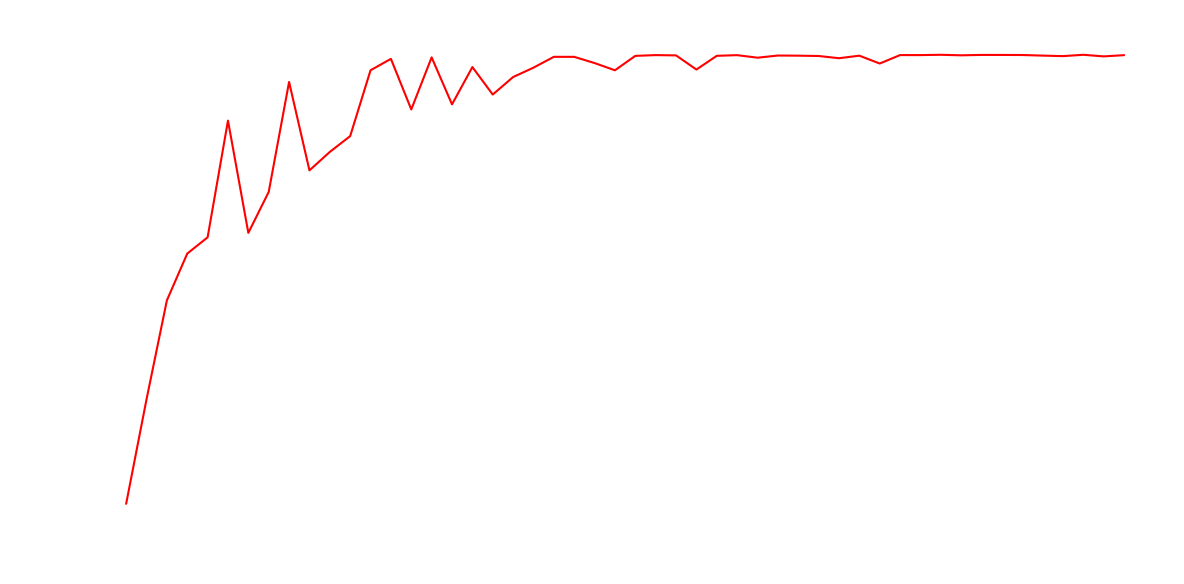

In [13]:
confidence_scores_CNN = [tensor.item() for tensor in confidence_scores_CNN]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Set background color to transparent
fig.patch.set_alpha(0)  # Set the figure background to transparent
ax1.set_facecolor((1, 1, 1, 0))  # Set axes background to transparent

# Set title and labels with white color
ax1.set_title("Mean confidence over epochs", fontsize=14, color='white')
ax1.set_xlabel("Epoch", color="white", fontsize=12)
ax1.set_ylabel("Confidence", color="white", fontsize=12)

# Plot the confidence scores
ax1.plot(confidence_scores_CNN, color='red')  # Set line color to white

# Customize ticks and grid
ax1.tick_params(axis="y", labelcolor='white', labelsize=12)
ax1.tick_params(axis='x', colors='white')
ax1.grid(True, linestyle="--", alpha=0.7, color='white')  # Set grid color to white

# Change spines color to white
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In [14]:
print(f"Final confidence on last epoch(training): {confidence_scores_CNN[-1]}")

Final confidence on last epoch(training): 0.999801754951477


Evaluate the model on the test set and see the accuracy.

In [15]:
# Evaluate the model on the test set
model.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader_CNN):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = model(x_e)
        softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc_CNN.append(trackingcorrect / num_elem)
    confidence_scores_CNN.append(softmax_probs.max(dim=1).values.mean())
    
print(f"Final test accuracy: {test_acc_CNN[-1]}")
print(f"Final confidence on test set: {confidence_scores_CNN[-1]}")

Final test accuracy: 0.9870327993897788
Final confidence on test set: 0.9997678995132446


Let's now work on the second model (AlexNet).

In [16]:
# Define the transformations for the training and testing datasets
transform_ALEX = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/classification/Training'
test_dir = 'datasets/classification/Testing'

# Create the datasets
train_dataset_ALEX = datasets.ImageFolder(root=train_dir, transform=transform_ALEX)
test_dataset_ALEX = datasets.ImageFolder(root=test_dir, transform=transform_ALEX)

# Create the DataLoaders
train_loader_ALEX: DataLoader = DataLoader(train_dataset_ALEX, batch_size=BATCH_TRAIN, shuffle=True)
test_loader_ALEX = DataLoader(test_dataset_ALEX, batch_size=BATCH_VALID, shuffle=False)

# Example of iterating through the DataLoader
for images, labels in train_loader_ALEX:
    print(images.shape, labels.shape)
    break


torch.Size([64, 3, 128, 128]) torch.Size([64])


Define the AlexNet model.

In [17]:
modelAlex: AlexNet_128 = AlexNet_128().to(device)
modelAlex.train()

AlexNet_128(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(9, 9), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (head): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias

See the number of parameters in the model.

In [18]:
# Total number of parameters
total_params = sum(p.numel() for p in modelAlex.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4589316


Define the optimizer.

In [19]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=modelAlex.parameters(), lr=LR, weight_decay=1e-5 # L2 regularization
)

# Let's define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

Train the model.

In [20]:
eval_losses_ALEX: List[float] = []
eval_acc_ALEX: List[float] = []
test_acc_ALEX: List[float] = []
confidence_scores_ALEX: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    modelAlex.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader_ALEX):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = modelAlex(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()
    
    # Step the scheduler
    scheduler.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    modelAlex.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader_ALEX):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = modelAlex(x_e)
            softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses_ALEX.append(trackingmetric / num_elem)
        eval_acc_ALEX.append(trackingcorrect / num_elem)
        confidence_scores_ALEX.append(softmax_probs.max(dim=1).values.mean())

Training epoch: 100%|██████████| 50/50 [17:44<00:00, 21.28s/it]


Plot the training loss and the accuracy of the model over the epochs.

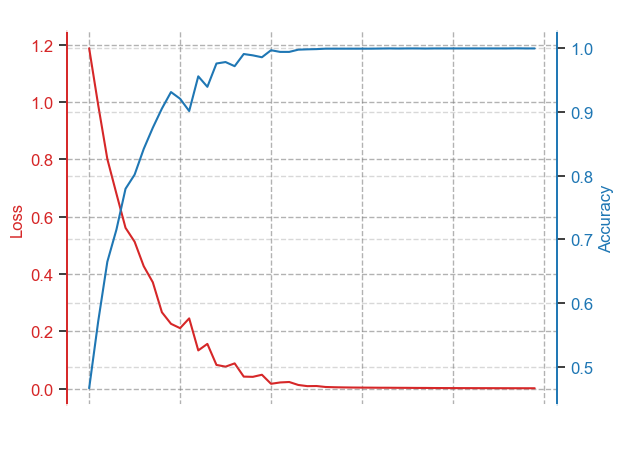

In [21]:
loss_color = "tab:red"
acc_color = "tab:blue"

# Create figure with transparent background
fig, ax1 = plt.subplots()

# Set background color to transparent
fig.patch.set_alpha(0)  # Set the figure background to transparent
ax1.set_facecolor((1, 1, 1, 0))  # Set axes background to transparent

# Set labels with white color
ax1.set_xlabel("Epoch", color="white", fontsize=12)
ax1.set_ylabel("Loss", color=loss_color, fontsize=12)
ax1.plot(eval_losses_ALEX, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color, labelsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color, fontsize=12)
ax2.plot(eval_acc_ALEX, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color, labelsize=12)

# Change ticks and spine colors to white
ax1.tick_params(axis='x', colors='white')
ax2.tick_params(axis='x', colors='white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color(loss_color)
ax1.spines['right'].set_color(acc_color)

ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
ax2.spines['left'].set_color(loss_color)
ax2.spines['right'].set_color(acc_color)

# Set title color to white
plt.title("Training loss and accuracy", fontsize=14, color='white')

# Adjust layout
fig.tight_layout()

plt.show()

See the final accuracy of the model.

In [22]:
print(f"Final training loss: {eval_losses_ALEX[-1]}")
print(f"Final training accuracy: {eval_acc_ALEX[-1]}")

Final training loss: 0.0012130674876563554
Final training accuracy: 0.9996498599439776


Let's analyze the confidences of the model.

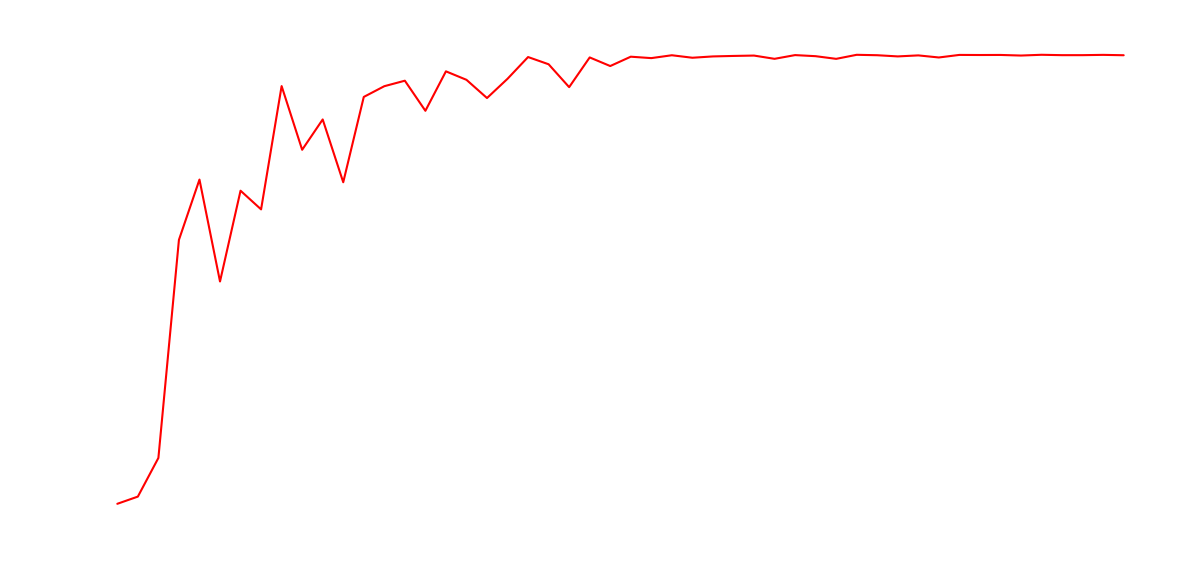

In [23]:
confidence_scores_ALEX = [tensor.item() for tensor in confidence_scores_ALEX]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Set background color to transparent
fig.patch.set_alpha(0)  # Set the figure background to transparent
ax1.set_facecolor((1, 1, 1, 0))  # Set axes background to transparent

# Set title and labels with white color
ax1.set_title("Mean confidence over epochs", fontsize=14, color='white')
ax1.set_xlabel("Epoch", color="white", fontsize=12)
ax1.set_ylabel("Confidence", color="white", fontsize=12)

# Plot the confidence scores
ax1.plot(confidence_scores_ALEX, color='red')  # Set line color to white

# Customize ticks and grid
ax1.tick_params(axis="y", labelcolor='white', labelsize=12)
ax1.tick_params(axis='x', colors='white')
ax1.grid(True, linestyle="--", alpha=0.7, color='white')  # Set grid color to white

# Change spines color to white
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In [24]:
print(f"Final confidence on last epoch(training): {confidence_scores_ALEX[-1]}")

Final confidence on last epoch(training): 0.9993839263916016


Evaluate the model on the test set and see the accuracy.

In [25]:
# Evaluate the model on the test set
modelAlex.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader_ALEX):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = modelAlex(x_e)
        softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc_ALEX.append(trackingcorrect / num_elem)
    confidence_scores_ALEX.append(softmax_probs.max(dim=1).values.mean())
    
print(f"Final test accuracy: {test_acc_ALEX[-1]}")
print(f"Final confidence on test set: {confidence_scores_ALEX[-1]}")

Final test accuracy: 0.8985507246376812
Final confidence on test set: 0.9652937650680542


Let's now work on the third model (VGG16).

In [26]:
# Define the transformations for the training and testing datasets
transform_VGG = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/classification/Training'
test_dir = 'datasets/classification/Testing'

# Create the datasets
train_dataset_VGG = datasets.ImageFolder(root=train_dir, transform=transform_VGG)
test_dataset_VGG = datasets.ImageFolder(root=test_dir, transform=transform_VGG)

# Create the DataLoaders
train_loader_VGG: DataLoader = DataLoader(train_dataset_VGG, batch_size=BATCH_TRAIN, shuffle=True)
test_loader_VGG = DataLoader(test_dataset_VGG, batch_size=BATCH_VALID, shuffle=False)

# Example of iterating through the DataLoader
for images, labels in train_loader_VGG:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


Define the VGG16 model.

In [27]:
modelVGG: VGG16_128 = VGG16_128().to(device)
modelVGG.train()

VGG16_128(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): double_conv(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv2): double_conv(
    (conv_block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv3): triple_conv(
    (conv_block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

See the number of parameters in the model.

In [28]:
# Total number of parameters
total_params = sum(p.numel() for p in modelVGG.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 65070916


Define the optimizer.

In [29]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=modelVGG.parameters(), lr=LR
)

Train the model.

In [30]:
eval_losses_VGG: List[float] = []
eval_acc_VGG: List[float] = []
test_acc_VGG: List[float] = []
confidence_scores_VGG: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    modelVGG.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader_VGG):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = modelVGG(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    modelVGG.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader_VGG):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = modelVGG(x_e)
            softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses_VGG.append(trackingmetric / num_elem)
        eval_acc_VGG.append(trackingcorrect / num_elem)
        confidence_scores_VGG.append(softmax_probs.max(dim=1).values.mean())

Training epoch: 100%|██████████| 50/50 [1:45:11<00:00, 126.23s/it]


Plot the training loss and the accuracy of the model over the epochs.

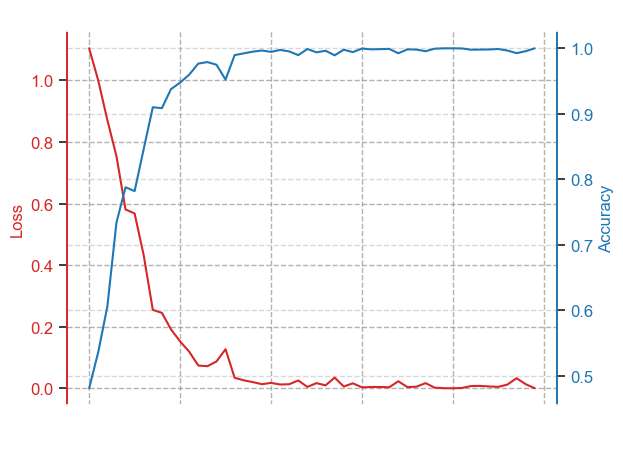

In [31]:
loss_color = "tab:red"
acc_color = "tab:blue"

# Create figure with transparent background
fig, ax1 = plt.subplots()

# Set background color to transparent
fig.patch.set_alpha(0)  # Set the figure background to transparent
ax1.set_facecolor((1, 1, 1, 0))  # Set axes background to transparent

# Set labels with white color
ax1.set_xlabel("Epoch", color="white", fontsize=12)
ax1.set_ylabel("Loss", color=loss_color, fontsize=12)
ax1.plot(eval_losses_VGG, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color, labelsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color, fontsize=12)
ax2.plot(eval_acc_VGG, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color, labelsize=12)

# Change ticks and spine colors to white
ax1.tick_params(axis='x', colors='white')
ax2.tick_params(axis='x', colors='white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color(loss_color)
ax1.spines['right'].set_color(acc_color)

ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
ax2.spines['left'].set_color(loss_color)
ax2.spines['right'].set_color(acc_color)

# Set title color to white
plt.title("Training loss and accuracy", fontsize=14, color='white')

# Adjust layout
fig.tight_layout()

plt.show()

See the final accuracy of the model.

In [32]:
print(f"Final training loss: {eval_losses_VGG[-1]}")
print(f"Final training accuracy: {eval_acc_VGG[-1]}")

Final training loss: 8.926302264802213e-05
Final training accuracy: 1.0


Let's analyze the confidences of the model.

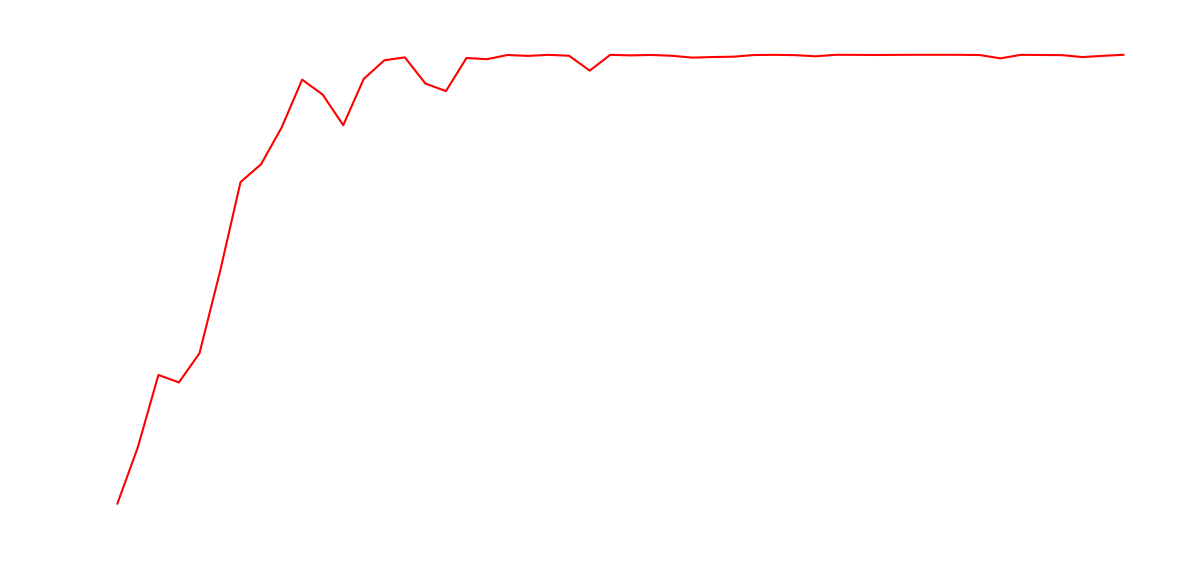

In [33]:
confidence_scores_VGG = [tensor.item() for tensor in confidence_scores_VGG]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Set background color to transparent
fig.patch.set_alpha(0)  # Set the figure background to transparent
ax1.set_facecolor((1, 1, 1, 0))  # Set axes background to transparent

# Set title and labels with white color
ax1.set_title("Mean confidence over epochs", fontsize=14, color='white')
ax1.set_xlabel("Epoch", color="white", fontsize=12)
ax1.set_ylabel("Confidence", color="white", fontsize=12)

# Plot the confidence scores
ax1.plot(confidence_scores_VGG, color='red')  # Set line color to white

# Customize ticks and grid
ax1.tick_params(axis="y", labelcolor='white', labelsize=12)
ax1.tick_params(axis='x', colors='white')
ax1.grid(True, linestyle="--", alpha=0.7, color='white')  # Set grid color to white

# Change spines color to white
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In [34]:
print(f"Final confidence on last epoch(training): {confidence_scores_VGG[-1]}")

Final confidence on last epoch(training): 0.9999929666519165


Evaluate the model on the test set and see the accuracy.

In [35]:
# Evaluate the model on the test set
modelVGG.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader_VGG):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = modelVGG(x_e)
        softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc_VGG.append(trackingcorrect / num_elem)
    confidence_scores_VGG.append(softmax_probs.max(dim=1).values.mean())
    
print(f"Final test accuracy: {test_acc_VGG[-1]}")
print(f"Final confidence on test set: {confidence_scores_VGG[-1]}")

Final test accuracy: 0.9534706331045004
Final confidence on test set: 0.9775871634483337


Let's now work on the fourth model (transformer VIT).

In [36]:
# Define the transformations for the training datasets (data augmentation)
transform_train_VIT = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation and hue
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the transformations for the testing datasets
transform_test_VIT = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/classification/Training'
test_dir = 'datasets/classification/Testing'

# Create the datasets
train_dataset_VIT = datasets.ImageFolder(root=train_dir, transform=transform_train_VIT)
test_dataset_VIT = datasets.ImageFolder(root=test_dir, transform=transform_test_VIT)

# Create the DataLoaders
train_loader_VIT: DataLoader = DataLoader(train_dataset_VIT, batch_size=BATCH_TRAIN, shuffle=True)
test_loader_VIT = DataLoader(test_dataset_VIT, batch_size=BATCH_VALID, shuffle=False)

# Example of iterating through the DataLoader
for images, labels in train_loader_VIT:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


Define the VIT model.

In [37]:
modelVIT: VisionTransformer = VisionTransformer().to(device)
modelVIT.train()

VisionTransformer(
  (patch_embed): Linear(in_features=768, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (transformer_layers): ModuleList(
    (0-9): 10 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (linear2): Linear(in_features=1024, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (to_cls_token): Identity()
  (mlp_head): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512

See the number of parameters in the model.

In [38]:
# Total number of parameters
total_params = sum(p.numel() for p in modelVIT.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 21459460


Define the optimizer and the scheduler.

In [39]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=modelVIT.parameters(), lr=LR, weight_decay=1e-5 # L2 regularization
)

# Let's define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

Train the model.

In [40]:
eval_losses_VIT: List[float] = []
eval_acc_VIT: List[float] = []
test_acc_VIT: List[float] = []
confidence_scores_VIT: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    modelVIT.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader_VIT):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = modelVIT(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()
        
    # Step the scheduler
    scheduler.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    modelVIT.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader_VIT):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = modelVIT(x_e)
            softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses_VIT.append(trackingmetric / num_elem)
        eval_acc_VIT.append(trackingcorrect / num_elem)
        confidence_scores_VIT.append(softmax_probs.max(dim=1).values.mean())

Training epoch: 100%|██████████| 50/50 [1:43:09<00:00, 123.78s/it]


Plot the training loss and the accuracy of the model over the epochs.

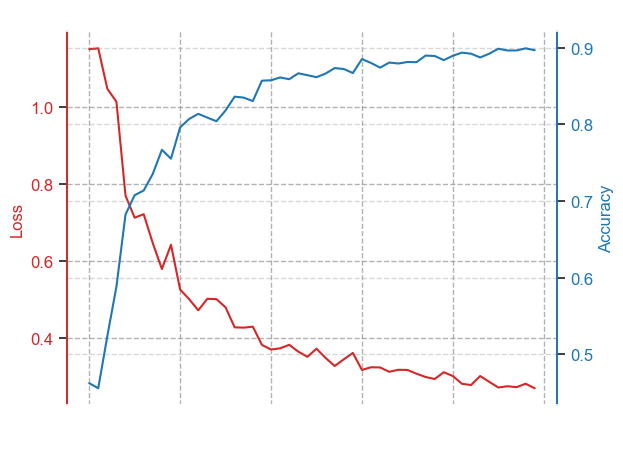

In [41]:
loss_color = "tab:red"
acc_color = "tab:blue"

# Create figure with transparent background
fig, ax1 = plt.subplots()

# Set background color to transparent
fig.patch.set_alpha(0)  # Set the figure background to transparent
ax1.set_facecolor((1, 1, 1, 0))  # Set axes background to transparent

# Set labels with white color
ax1.set_xlabel("Epoch", color="white", fontsize=12)
ax1.set_ylabel("Loss", color=loss_color, fontsize=12)
ax1.plot(eval_losses_VIT, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color, labelsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color, fontsize=12)
ax2.plot(eval_acc_VIT, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color, labelsize=12)

# Change ticks and spine colors to white
ax1.tick_params(axis='x', colors='white')
ax2.tick_params(axis='x', colors='white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color(loss_color)
ax1.spines['right'].set_color(acc_color)

ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
ax2.spines['left'].set_color(loss_color)
ax2.spines['right'].set_color(acc_color)

# Set title color to white
plt.title("Training loss and accuracy", fontsize=14, color='white')

# Adjust layout
fig.tight_layout()

plt.show()

See the final accuracy of the model.

In [42]:
print(f"Final training loss: {eval_losses_VIT[-1]}")
print(f"Final training accuracy: {eval_acc_VIT[-1]}")

Final training loss: 0.2708046309002975
Final training accuracy: 0.8965336134453782


Let's analyze the confidences of the model.

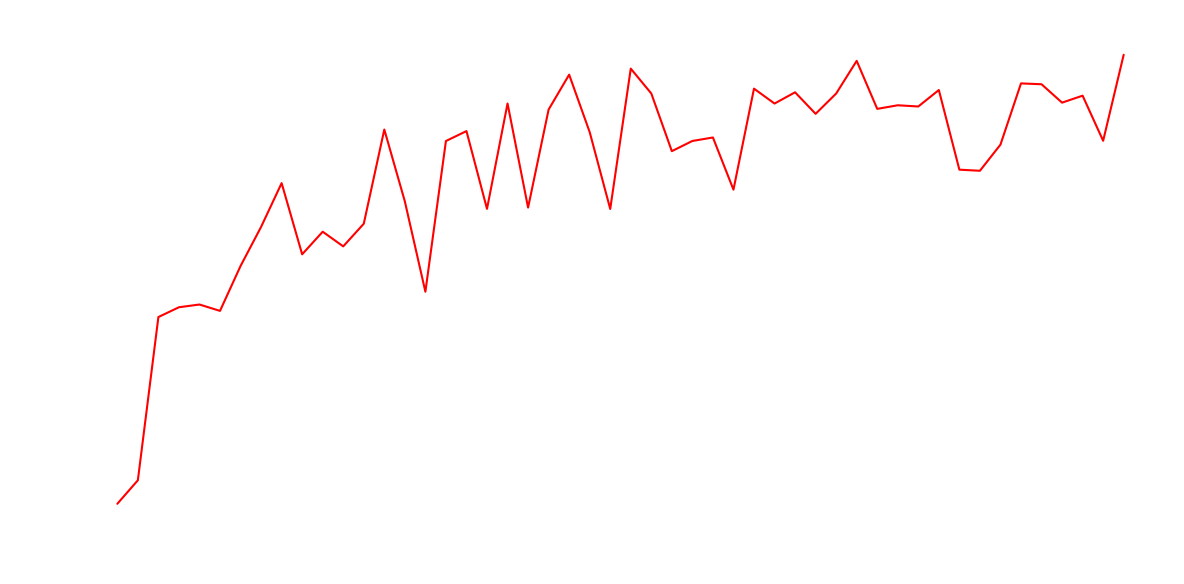

In [43]:
confidence_scores_VIT = [tensor.item() for tensor in confidence_scores_VIT]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Set background color to transparent
fig.patch.set_alpha(0)  # Set the figure background to transparent
ax1.set_facecolor((1, 1, 1, 0))  # Set axes background to transparent

# Set title and labels with white color
ax1.set_title("Mean confidence over epochs", fontsize=14, color='white')
ax1.set_xlabel("Epoch", color="white", fontsize=12)
ax1.set_ylabel("Confidence", color="white", fontsize=12)

# Plot the confidence scores
ax1.plot(confidence_scores_VIT, color='red')  # Set line color to white

# Customize ticks and grid
ax1.tick_params(axis="y", labelcolor='white', labelsize=12)
ax1.tick_params(axis='x', colors='white')
ax1.grid(True, linestyle="--", alpha=0.7, color='white')  # Set grid color to white

# Change spines color to white
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In [44]:
print(f"Final confidence on last epoch(training): {confidence_scores_VIT[-1]}")

Final confidence on last epoch(training): 0.9606032371520996


Evaluate the model on the test set and see the accuracy.

In [45]:
# Evaluate the model on the test set
modelVIT.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader_VIT):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = modelVIT(x_e)
        softmax_probs = th.nn.functional.softmax(modeltarget_e, dim=1)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc_VIT.append(trackingcorrect / num_elem)
    confidence_scores_VIT.append(softmax_probs.max(dim=1).values.mean())
    
print(f"Final test accuracy: {test_acc_VIT[-1]}")
print(f"Final confidence on test set: {confidence_scores_VIT[-1]}")

Final test accuracy: 0.8810068649885584
Final confidence on test set: 0.9328330159187317


Plot the accuracies of all the models over the epochs.

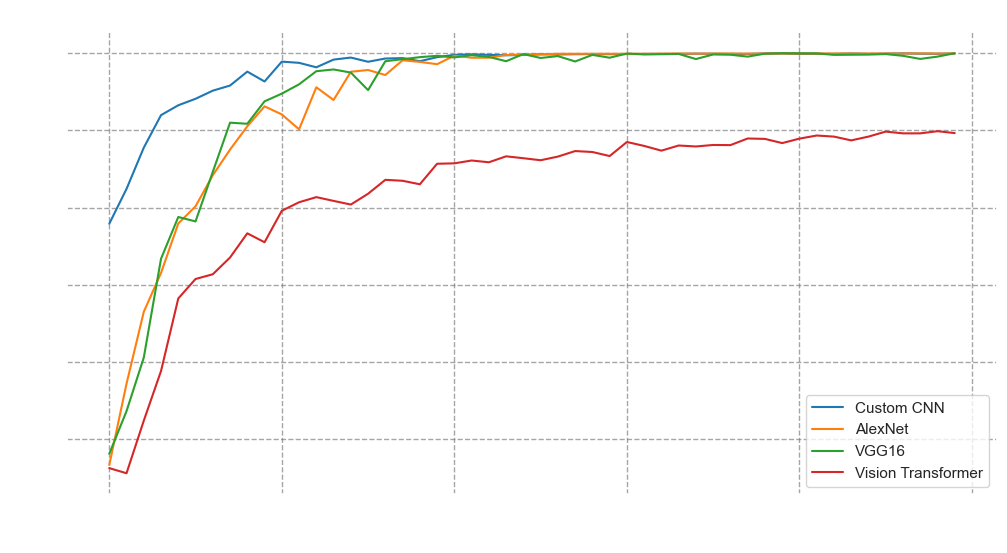

In [47]:
plt.figure(figsize=(12, 6))
plt.title("Training accuracy comparison", fontsize=14, color="white")
plt.plot(eval_acc_CNN, label="Custom CNN", color="tab:blue")
plt.plot(eval_acc_ALEX, label="AlexNet", color="tab:orange")
plt.plot(eval_acc_VGG, label="VGG16", color="tab:green")
plt.plot(eval_acc_VIT, label="Vision Transformer", color="tab:red")
plt.xlabel("Epoch", fontsize=12, color="white")
plt.ylabel("Accuracy", fontsize=12, color="white")
plt.legend(facecolor='white')
plt.grid(True, linestyle="--", alpha=0.7)

# Set transparent background
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)

# Customize tick colors
plt.xticks(fontsize=12, color="white")
plt.yticks(fontsize=12, color="white")

# Customize axis colors
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')

plt.show()

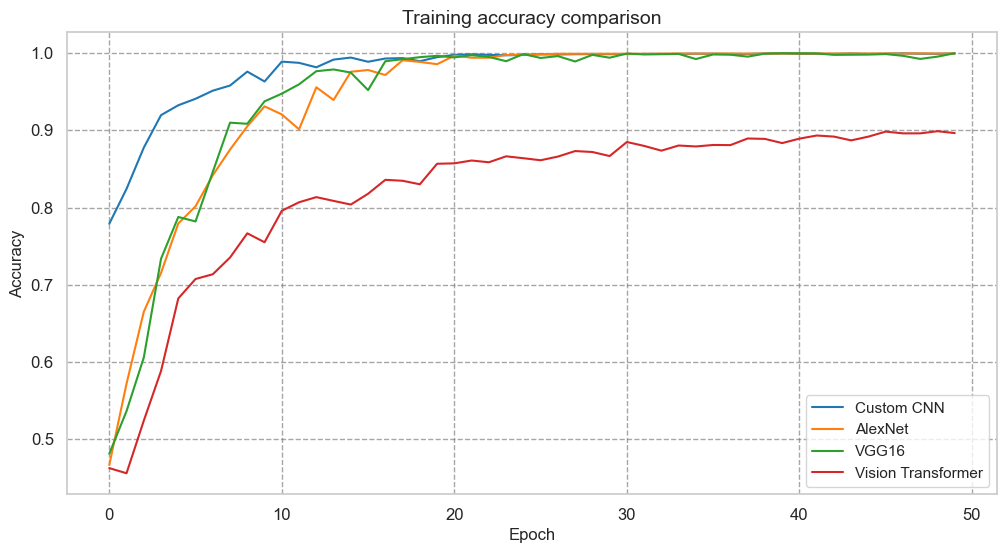

In [46]:
plt.figure(figsize=(12, 6))
plt.title("Training accuracy comparison", fontsize=14)
plt.plot(eval_acc_CNN, label="Custom CNN", color="tab:blue")
plt.plot(eval_acc_ALEX, label="AlexNet", color="tab:orange")
plt.plot(eval_acc_VGG, label="VGG16", color="tab:green")
plt.plot(eval_acc_VIT, label="Vision Transformer", color="tab:red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()